In [1]:
from __future__ import absolute_import, division, print_function

import functools
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint

In [2]:
tf.__version__

'2.0.0'

In [3]:
tf.executing_eagerly()

True

In [4]:
tf.test.is_gpu_available()

False

## Generating Discrete Harmonic Functions on the Square

The Harmonic functions on the square A of size N are those functions that satisfy:
$$f(i, j) = \frac{1}{4}\bigg(f(i-1, j) + f(i+1, j) + f(i,j-1) + f(i,j+1)\bigg)$$
for all $i,j \in \{1, 2, ..., N-1\}$.  These functions are uniquely determined by their values on the boundary of the square: $i\in\{0,N\}\text{ or }j\in\{0,N\}$.  

What follows is a summary of http://www.math.uchicago.edu/~lawler/reu.pdf, section 1.5.

Let $e_k$ refer to the function defined on $\partial A$ that is equal to 1 at the $k$th position at the bottom of the square and is equal 0 elsewhere.  Then the harmonic function on the interior of the square that is equal to $e_k$ on the boundary is given by:
$$H_{(N, e_k)}(x_1, x_2) = \frac{2}{N-1}\sum_{j=1}^{N-1}\frac{1}{\sinh(\beta_j)}\sin\left(\frac{j\pi k}{N}\right)\sinh\left(\frac{\beta_jx_1}{N}\right)\sin\left(\frac{j\pi x_2}{N}\right)$$
where $\beta_j\text{ for }j\in\{1, 2, ..., N-1\}$ solves:
$$ \cosh\left(\frac{\beta_j}{N}\right) + \cos\left(\frac{j\pi}{N}\right) = 2$$
These functions, combined with similar functions for the other sides of the square, form a basis for the space of all harmonic functions on the interior of the square.  This is implemented below.

In [5]:
harmonic_basis_cache={}

def generate_beta(n):
    return [n*(np.arccosh(2-np.cos(j*np.pi/n))) for j in range(1,n)]
  
def poisson_kernel_square_raw(n, y, x_1, x_2):
    beta = generate_beta(n)
    h = [np.sinh(beta[j-1] * x_1 / n) 
        * np.sin(j * np.pi * x_2 / n) for j in range(1, n)]
    c = [1/np.sinh(beta[j-1]) 
        * np.sin(j * np.pi * y / n) for j in range(1, n)]
    return 2/(n) * sum([c[j-1] * h[j-1] for j in range(1, n)])
  
def poisson_kernel_square(n, y):
    return lambda x_1, x_2: poisson_kernel_square_raw(n, y, x_1, x_2)
  
    
def harmonic_basis(n, k):
    if (n,k) in harmonic_basis_cache.keys():
        return harmonic_basis_cache[n,k]
    x = np.zeros(shape=[n+1, n+1])
    x[n,k] = 1
    H = poisson_kernel_square(n, k)
    for i in range(1, n):
        for j in range(1, n):
            x[i, j] = H(i, j)
    harmonic_basis_cache[n,k] = x
    return x
  
# This is O(n^3) at the moment.
# This is due to each of n basis functions taking O(n^2) steps to compute.
# Can this be improved?  Do we care?
def generate_harmonic_one_side(n, y, side='lower'):
    lower = np.sum([y[j-1] * harmonic_basis(n,j) for j in range(1, n)], axis=0)
    if side == 'upper':
        return np.flip(lower, axis=0)
    if side == 'left':
        return np.rot90(lower, k=3)
    if side == 'right':
        return np.rot90(np.flip(lower, axis=0), k=3)
    if side == 'lower':
        return lower

def generate_harmonic(n, y):
    """Here y specifies the entire boundary, going in order of upper, left, right, lower."""
    upper = generate_harmonic_one_side(n, y[:n-1], side='upper')
    left = generate_harmonic_one_side(n, y[n-1:2*n-2], side='left')
    right = generate_harmonic_one_side(n, y[2*n-2:3*n-3], side='right')
    lower = generate_harmonic_one_side(n, y[3*n-3:], side='lower')
    return upper + left + right + lower

In [6]:
def is_harmonic_at_point(x, i, j, tol=.000001, verbose=False):
    diff = np.abs(x[i, j] - np.mean([x[i-1,j], x[i+1,j], x[i,j-1], x[i,j+1]])) 
    if verbose:
        print("|{} - {}| = {}".format(x[i,j], 
                                      np.mean([x[i-1,j], x[i+1,j], x[i,j-1], x[i,j+1]]), 
                                      diff))
    return diff <= tol
  
def is_harmonic(x, n, tol=.000001, verbose=False):
    for i in range(1, n):
        for j in range(1, n):
            if not is_harmonic_at_point(x, i, j, tol=tol, verbose=verbose):
                if verbose:
                    print((i,j))
                return False
    return True

## Generating Non-Harmonic Functions.

The question of what to use as a negative for the model deserves a lot of thought.  At present I have two approaches: 

In the first approach, I use \\((N+1)^2\\) independent Gaussian random variables to generate non-harmonic functions.  The likelihood that these will be harmonic is negligible.  

In the second approach I generate a harmonic function, and add a gaussian density to the result.  Since the gaussian is not harmonic (it in particular violates the maximum modulus principle), the resulting sum is not harmonic.

In [7]:
def generate_nonharmonic(n):
    x = np.random.randn(n+1,n+1)
    x[0,0] = 0.
    x[0,n] = 0.
    x[n,0] = 0.
    x[n,n] = 0.
    return x

In [8]:
grv_cache={}

# This is slow, need to make better use of numpy to 
# generate these, possibly with memoization as above.
def generate_gaussian(n, strength):
    mean = np.random.randint(1,n, size=2)
    cov = (n/2 - .5) * np.random.random(size=2) + .5
    amplitude = strength * np.random.choice([1,-1])
    rv = multivariate_normal(mean=mean, cov=cov)
    x = rv.pdf(np.array(np.meshgrid(np.arange(n+1), np.arange(n+1))).T)
    return amplitude * x

def generate_harmonic_plus_noise(n, y, strength=.1):
    harmonic = generate_harmonic(n, y)
    output = harmonic + generate_gaussian(n, strength=strength)
    return output

In [9]:
def visualize(examples, n, cmap='cividis'):
    num_examples = len(examples)
    fig, axes = plt.subplots(1, num_examples, figsize=(n+1,n+1))
    if num_examples == 1:
        axes.imshow(examples[0], cmap=cmap)
        axes.axis('off')
        plt.show()
        return
    axes = axes.flatten()
    for x, ax in zip(examples, axes):
        ax.imshow(x, cmap=cmap)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Data Preparation

In [10]:
def harmonic_data_generator(n):
    while True:
        if np.random.rand() < .5:
            y = np.random.randn(4*(n-1))
            yield np.reshape(generate_harmonic(n,y), (n+1, n+1)).astype(np.float32), 1
        else:
            yield np.reshape(generate_nonharmonic(n), (n+1, n+1)).astype(np.float32), 0

In [11]:
def mixed_harmonic_data_generator(n):
    while True:
        x = np.random.rand()
        if x < .25:
            y = np.random.randn(4*(n-1))
            yield np.reshape(generate_harmonic(n,y), (n+1, n+1)).astype(np.float32), 1
        if x < .5:
            y = np.random.choice([-1, 0, 1, 2, 10], p=[.39, .3, .2, .1, .01], size=(36,))
            yield np.reshape(generate_harmonic(n,y), (n+1, n+1)).astype(np.float32), 1
        elif x < .7:
            y = np.random.randn(4*(n-1))
            strength = np.random.rand()
            yield np.reshape(generate_harmonic_plus_noise(n,y,strength=strength), (n+1, n+1)).astype(np.float32), 0
        elif x < .9:
            y = np.random.choice([-1, 0, 1, 2, 10], p=[.39, .3, .2, .1, .01], size=(36,))
            strength = np.random.rand()
            yield np.reshape(generate_harmonic_plus_noise(n,y,strength=strength), (n+1, n+1)).astype(np.float32), 0
        elif x < 1.:
            yield np.reshape(generate_nonharmonic(n), (n+1, n+1)).astype(np.float32), 0

In [12]:
def visualize_dataset(dataset, n, num_examples=5, cmap='cividis'):
    examples = [item for item in dataset.take(num_examples)]
    fig, axes = plt.subplots(1, num_examples, figsize=(n+1,n+1))
    axes = axes.flatten()
    for x, ax in zip(examples, axes):
        ax.imshow(x[0], cmap=cmap, vmin=-3, vmax=3)
        if x[1]:
            ax.set_title("Harmonic")
        else:
            ax.set_title("Nonharmonic")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
n=10
dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

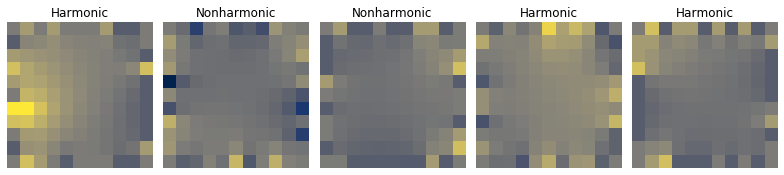

In [14]:
visualize_dataset(dataset, n, num_examples=5)

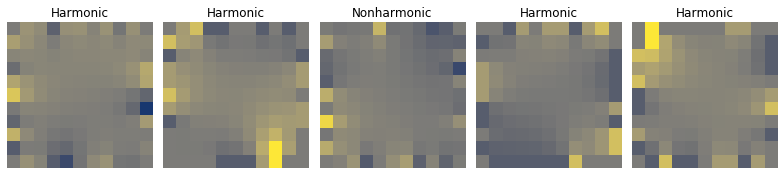

In [15]:
visualize_dataset(dataset, n, num_examples=5)

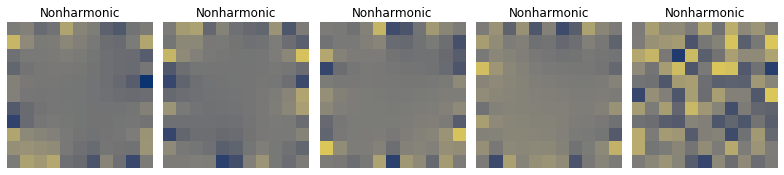

In [16]:
visualize_dataset(dataset, n, num_examples=5)

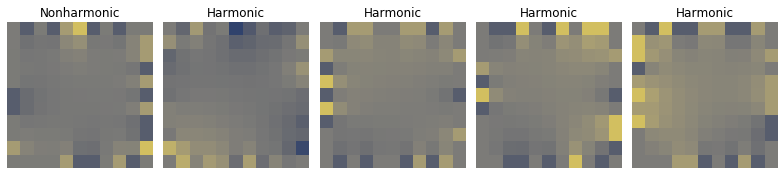

In [17]:
visualize_dataset(dataset, n, num_examples=5)

## Controllers

In [18]:
class DiffEqController(tf.keras.callbacks.Callback):
    
    def __init__(self, precisions, verbose=False):
        super(DiffEqController, self).__init__()
        self.precisions = precisions
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs):
        precision = precisions[epoch]
        if self.verbose:
            print("Precision={}".format(precision))
        output_weights = np.array([[-2/(precision**2)], [-2/(precision**2)]])
        output_biases = np.array([1/(4*(precision)**2)])
        self.model.layers[-1].set_weights((output_weights, output_biases))

## Constraints

In [19]:
import tensorflow.keras.backend as K

In [20]:
class ProbMeasure(tf.keras.constraints.Constraint):
    """Constrains the weights incident to each hidden unit to be a probability measure.
    """

    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, w):
        w = w * K.cast(K.greater_equal(w, 0.), K.floatx())
        return w / (K.epsilon() + K.sum(K.abs(w),
                                        axis=self.axis,
                                        keepdims=True))

    def get_config(self):
        return {'axis': self.axis}

## Models

In [21]:
class DiffeqModel(tf.keras.Model):
    
    def __init__(self, n, filter_size):
        super(DiffeqModel, self).__init__(name='diffeq_model')
        self.n = n
        self.reshape = tf.keras.layers.Reshape((n+1,n+1,1), input_shape=(n+1,n+1))
        self.conv2D = tf.keras.layers.Conv2D(filter_size, 
                                             kernel_size=3,
                                             input_shape=(n+1, n+1, 1),
                                             kernel_regularizer=tf.keras.regularizers.l2(.001),)
        self.dense = tf.keras.layers.Dense(1, 
                                           activation='relu', 
                                           kernel_constraint=ProbMeasure(),
                                           kernel_regularizer=tf.keras.regularizers.l1(.01))
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=n-1)
        self.flatten = tf.keras.layers.Flatten()
        output_kernel_initializer = tf.keras.initializers.Constant([[-1., -1.]])
        output_bias_initializer = tf.keras.initializers.Constant([.2])
        self.output_layer = tf.keras.layers.Dense(1, 
                                                  activation='sigmoid', 
                                                  kernel_initializer = output_kernel_initializer,
                                                  bias_initializer = output_bias_initializer,
                                                  trainable=False)
        
    def call(self, input_tensor, training=False):
        x = self.reshape(input_tensor)
        x = self.conv2D(x)
        x1 = tf.nn.relu(x)
        x2 = tf.nn.relu(-1*x)
        x1 = self.dense(x1)
        x2 = self.dense(x2)
        x = tf.concat([x1, x2], axis=-1)
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.output_layer(x)


## Another Variant on Training

In [22]:
n=5

In [23]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator,
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [24]:
mixed_dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                               args=[n], 
                                               output_types=(tf.float32, tf.bool), 
                                               output_shapes = ((n+1,n+1), ()))

In [25]:
model = DiffeqModel(n, 32)

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [27]:
epochs = 60
precisions = [1., 1., 1., 1., 1.,
              .7, .7, .7, .7, .7,
              .5, .5, .5, .5, .5,
              .35, .35, .35, .35, .35,
              .2, .2, .2, .2, .2,
              .1, .1, .1, .1, .1,
              .05, .05, .05, .05, .05,
              .03, .03, .03, .03, .03,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01]

diffeq_controller = DiffEqController(precisions)

In [28]:
def diff_eq_schedule(epoch, lr, precisions):
    if epoch == 0:
        return lr
    old_precision, new_precision = precisions[epoch-1], precisions[epoch]
    if new_precision == old_precision:
        return (4/5) * lr
    return min(.001, 2*(new_precision ** 2))

def get_diff_eq_schedule(precisions):
    return lambda epoch, lr: diff_eq_schedule(epoch, lr, precisions)

def geometric_schedule(rate=.9):
    return lambda epoch, lr: lr*rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(get_diff_eq_schedule(precisions))

In [58]:
h = model.fit(mixed_dataset.batch(64), epochs=epochs, steps_per_epoch=100, callbacks=[diffeq_controller, lr_schedule])

Train for 100 steps
Epoch 1/60
 66/100 [==================>...........] - ETA: 4s - loss: 0.6513 - accuracy: 0.9632

KeyboardInterrupt: 

In [30]:
model.layers[2].get_weights()

[array([[-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [ 2.4199473e-04],
        [-0.0000000e+00],
        [ 1.5064467e-01],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [ 2.6180062e-02],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [ 2.9848197e-01],
        [-0.0000000e+00],
        [ 5.2445120e-01],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00],
        [-0.0000000e+00]], dtype=float32), array([-0.00766576], dtype=float32)]

In [31]:
model.layers[1].get_weights()[0][:,:,:,16]

array([[[ 5.6838145e-04],
        [-1.0244076e-04],
        [ 2.4099027e-05]],

       [[-7.0310285e-05],
        [ 3.8740804e-06],
        [ 2.6714866e-04]],

       [[-3.3481661e-05],
        [-5.8082346e-04],
        [-4.3834606e-03]]], dtype=float32)

In [32]:
model.summary()

Model: "diffeq_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
dense (Dense)                multiple                  33        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  3         
Total params: 356
Trainable params: 353
Non-trainable params: 3
________________________________________________________

In [33]:
ce = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        ce[i,j] = 2.5 - np.max([np.abs(2.5 - i), np.abs(2.5 - j)])

In [34]:
ce

array([[0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0.],
       [0., 1., 2., 2., 1., 0.],
       [0., 1., 2., 2., 1., 0.],
       [0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [35]:
model.predict(ce.reshape(1,6,6))

array([[0.]], dtype=float32)

In [36]:
model.predict(-1*ce.reshape(1,6,6))

array([[0.]], dtype=float32)

In [37]:
def test_on_harmonic_pertubations(n, y):
    x = generate_harmonic(n, y)
    visualize([x], n)
    perturbations = [1., .5, .1, .05, .01, .025, .001]
    harmonic_prediction = model.predict(x.reshape(1, n+1, n+1))[0,0]
    print('Harmonic: {}'.format(harmonic_prediction))
    for perturbation in perturbations:
        y = x.copy()
        y[2, 2] = y[2,2] - perturbation
        prediction = model.predict(y.reshape(1, n+1, n+1))[0,0]
        print('Perturbation {}: {}'.format(perturbation, prediction))

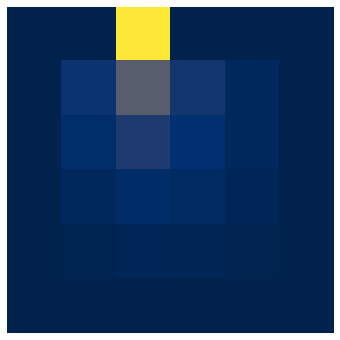

Harmonic: 0.9776551723480225
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 0.0
Perturbation 0.05: 0.0
Perturbation 0.01: 0.0
Perturbation 0.025: 0.0
Perturbation 0.001: 0.8120489120483398


In [38]:
test_on_harmonic_pertubations(5, 10 * np.identity(16)[1])


## Another Variant on Training

In [60]:
n=10

In [61]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator,
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [62]:
mixed_dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                               args=[n], 
                                               output_types=(tf.float32, tf.bool), 
                                               output_shapes = ((n+1,n+1), ()))

In [63]:
model = DiffeqModel(n, 32)

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [65]:
epochs = 60
precisions = [1., 1., 1., 1., 1.,
              .7, .7, .7, .7, .7,
              .5, .5, .5, .5, .5,
              .35, .35, .35, .35, .35,
              .2, .2, .2, .2, .2,
              .1, .1, .1, .1, .1,
              .05, .05, .05, .05, .05,
              .03, .03, .03, .03, .03,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01]

diffeq_conroller = DiffEqController(precisions)

In [66]:
def diff_eq_schedule(epoch, lr, precisions):
    if epoch == 0:
        return lr
    old_precision, new_precision = precisions[epoch-1], precisions[epoch]
    if new_precision == old_precision:
        return (4/5) * lr
    return min(.001, 2*(new_precision ** 2))

def get_diff_eq_schedule(precisions):
    return lambda epoch, lr: diff_eq_schedule(epoch, lr, precisions)

def geometric_schedule(rate=.9):
    return lambda epoch, lr: lr*rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(get_diff_eq_schedule(precisions))

In [67]:
h = model.fit(mixed_dataset.batch(64), epochs=epochs, steps_per_epoch=100, callbacks=[diffeq_conroller, lr_schedule])

Train for 100 steps
Epoch 1/60
100/100 [==============================] - 15s 147ms/step - loss: 0.7375 - accuracy: 0.5327
Epoch 2/60
100/100 [==============================] - 12s 121ms/step - loss: 0.6656 - accuracy: 0.6558
Epoch 3/60
100/100 [==============================] - 10s 105ms/step - loss: 0.6435 - accuracy: 0.6820
Epoch 4/60
100/100 [==============================] - 328s 3s/step - loss: 0.6310 - accuracy: 0.6916
Epoch 5/60
100/100 [==============================] - 18s 179ms/step - loss: 0.6375 - accuracy: 0.6748
Epoch 6/60
100/100 [==============================] - 14s 140ms/step - loss: 0.6119 - accuracy: 0.6755
Epoch 7/60
100/100 [==============================] - 14s 135ms/step - loss: 0.6073 - accuracy: 0.6819
Epoch 8/60
100/100 [==============================] - 13s 133ms/step - loss: 0.6051 - accuracy: 0.6841
Epoch 9/60
100/100 [==============================] - 13s 133ms/step - loss: 0.6057 - accuracy: 0.6858
Epoch 10/60
100/100 [==============================] - 

KeyboardInterrupt: 

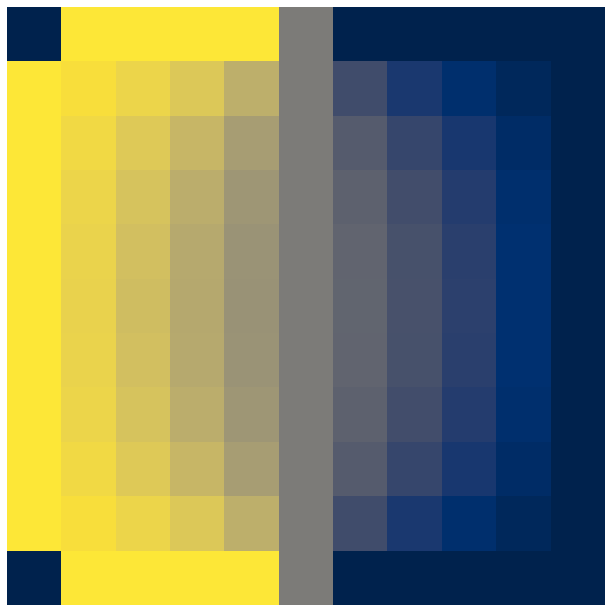

Harmonic: 0.937397301197052
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 0.0
Perturbation 0.05: 0.0
Perturbation 0.01: 0.0
Perturbation 0.025: 0.0
Perturbation 0.001: 0.016324440017342567


In [47]:
test_on_harmonic_pertubations(10, [1,1,1,1,.5,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,.5,0,0,0,0])

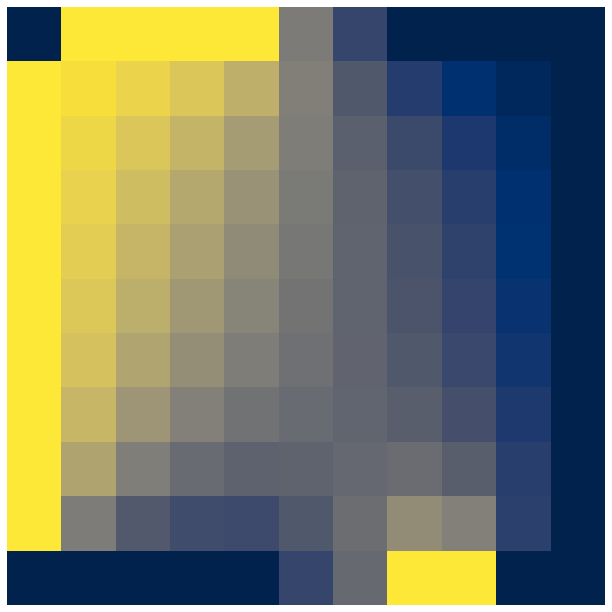

Harmonic: 0.9366771578788757
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 0.0
Perturbation 0.05: 0.0
Perturbation 0.01: 0.0
Perturbation 0.025: 0.0
Perturbation 0.001: 0.016304848715662956


In [48]:
test_on_harmonic_pertubations(10, 10*[1,1,1,1,.5,.2,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,.2,.4,1,1,0])

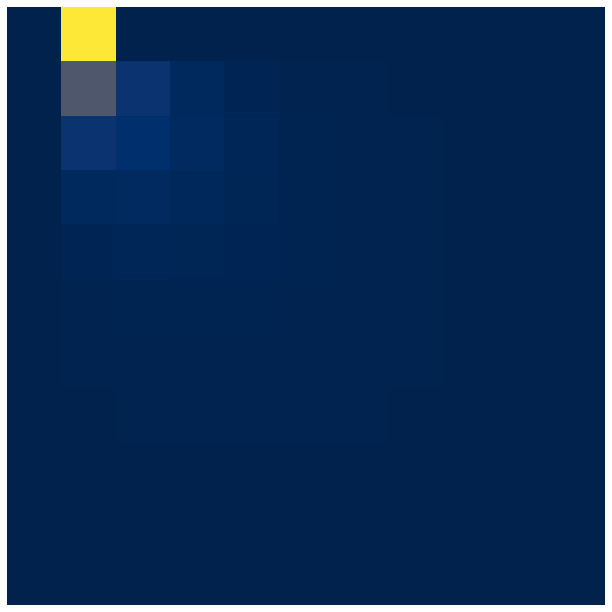

Harmonic: 0.9368362426757812
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 0.0
Perturbation 0.05: 0.0
Perturbation 0.01: 0.0
Perturbation 0.025: 0.0
Perturbation 0.001: 0.0157164353877306


In [49]:
test_on_harmonic_pertubations(10, np.identity(81)[0])

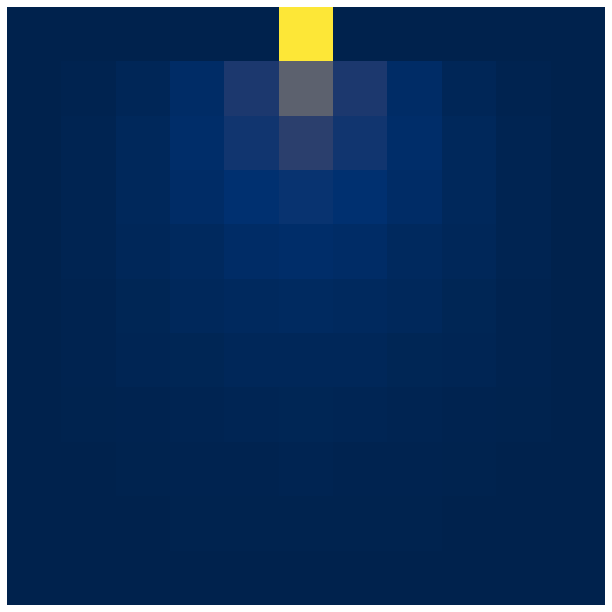

Harmonic: 0.9109225273132324
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 0.0
Perturbation 0.05: 0.0
Perturbation 0.01: 0.0
Perturbation 0.025: 0.0
Perturbation 0.001: 0.01692303456366062


In [50]:
test_on_harmonic_pertubations(10, 20*np.identity(81)[4])

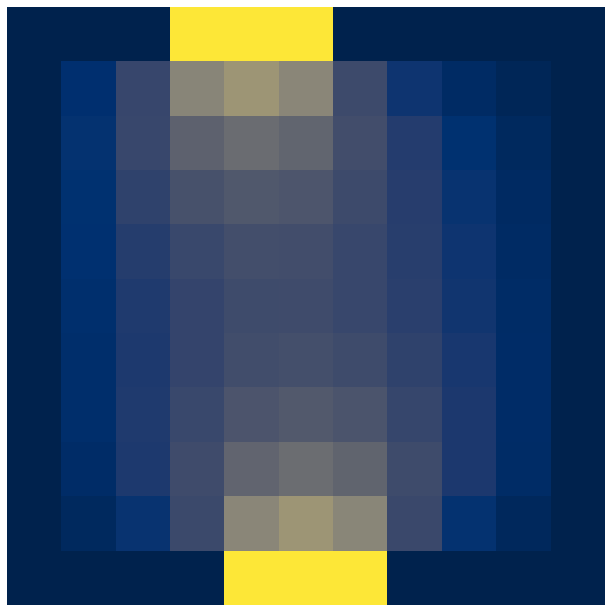

Harmonic: 0.937210738658905
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 0.0
Perturbation 0.05: 0.0
Perturbation 0.01: 0.0
Perturbation 0.025: 0.0
Perturbation 0.001: 0.01605226844549179


In [51]:
test_on_harmonic_pertubations(10, np.identity(36)[2]+np.identity(36)[3]+np.identity(36)[4]+np.identity(36)[30]+np.identity(36)[31]+np.identity(36)[32])

In [52]:
model.layers[2].get_weights()[0]

array([[-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.21522082],
       [-0.        ],
       [ 0.77700627],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [ 0.00777278],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ]], dtype=float32)

In [55]:
model.layers[1].get_weights()[0][:,:,:,10]

array([[[-0.00122403],
        [-0.10652273],
        [-0.00127733]],

       [[-0.10810645],
        [ 0.42339233],
        [-0.10486642]],

       [[-0.00158578],
        [-0.1040621 ],
        [-0.00124709]]], dtype=float32)

In [57]:
model.layers[1].get_weights()[0][:,:,:,8]

array([[[ 0.00467547],
        [-0.01025317],
        [ 0.00444748]],

       [[-0.00489401],
        [ 0.05296471],
        [-0.01652846]],

       [[ 0.00568778],
        [-0.01964219],
        [ 0.00436661]]], dtype=float32)